# Laboratorio 3 - Clasificación y Regresión


En este laboratorio trabajaremos con algoritmos de clustering y reglas de asociación sobre 3 datasets:

1. __E-Commerce Data:__ Este dataset contiene transacciones realizadas por una empresa de e-commerce en distintos paises. Lo puede encontrar en el siguiente [link](https://www.kaggle.com/datasets/carrie1/ecommerce-data)
2. __Bank Customer Churn:__ Este dataset contiene información de clientes de un banco, dentro de esta base se encuentran tanto clientes fugados como no fugados. Puede encontrar el dataset en el siguiente [link](https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn)
3. __Global poverty and inequality dataset:__ Este daataset contiene información socio-demográfica proveniente del banco mundial referente a varios paises. Puede encontrar el dataset en el siguiente [link](https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv)


### Imports

In [101]:
import opendatasets as od
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import numpy as np

import scipy
from scipy.stats import gaussian_kde

In [102]:
"""Descargamos los datasets
od.download("https://www.kaggle.com/datasets/carrie1/ecommerce-data")
od.download("https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn")
od.download("https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv")
"""

'Descargamos los datasets\nod.download("https://www.kaggle.com/datasets/carrie1/ecommerce-data")\nod.download("https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn")\nod.download("https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv")\n'

In [103]:
#Cargar csv's
bank_df= pd.read_csv("bank-customer-churn/Customer-Churn-Records.csv")
ecom_df=df = pd.read_csv("ecommerce-data/data.csv", encoding= 'unicode_escape')
poverty_df= df = pd.read_csv("global-poverty-and-inequality-dataset/pip_dataset.csv")


# Preguntas

## 1. Bank Customer Churn (35 pts)
Es de interés saber qué perfil tienen los clientes que más se fugan del banco y aquellos que son más leales (menos fuga). Resuelva este problema usando modelos de clustering y posteriormente ajuste algún modelo de clasificación, validándolos según las métricas vistas en clases para ambos tipos de problemas. Discuta el desempeño por separado de ambos modelos en su respectivo problema y discuta con qué aproximación se quedaría usted para reportar los perfiles. ¿Cómo describiría usted los perfiles encontrados? (si son muchos basta discutir los que poseen mayor cantidad de elementos).



In [104]:
bank_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# Limpieza del dataset

In [105]:
def discretizar_columna(dataframe, columname):
    lista_a_buscar = dataframe[columname].unique().tolist()
    lista = []

    for val in dataframe[columname]:
        lista.append(lista_a_buscar.index(val))
    
    dataframe["d_"+columname] = lista
    dataframe = dataframe.drop(columns = [columname])

    return dataframe

In [106]:
bank_df.columns = [i.lower().replace(' ','_') for i in bank_df.columns]
print("Tiene algun elemento vacio? : {}".format(bank_df.isnull().any().any()))

# Drop unnecessary columns
bank_df = bank_df.drop(columns = ['rownumber','customerid', "surname"])
bank_df

Tiene algun elemento vacio? : False


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction_score,card_type,point_earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


In [107]:
# Discretizamos las columnas categóricas 
bank_df = discretizar_columna(bank_df, "geography")
bank_df = discretizar_columna(bank_df, "gender")
bank_df = discretizar_columna(bank_df, "card_type")
bank_df

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction_score,point_earned,d_geography,d_gender,d_card_type
0,619,42,2,0.00,1,1,1,101348.88,1,1,2,464,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,3,456,1,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,3,377,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,5,350,0,0,1
4,850,43,2,125510.82,1,1,1,79084.10,0,0,5,425,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,1,300,0,1,0
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,5,771,0,1,3
9997,709,36,7,0.00,1,0,1,42085.58,1,1,3,564,0,0,2
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,2,339,2,1,1


## Modelos de clustering 

### KMeans

[2 2 0 ... 2 3 0]


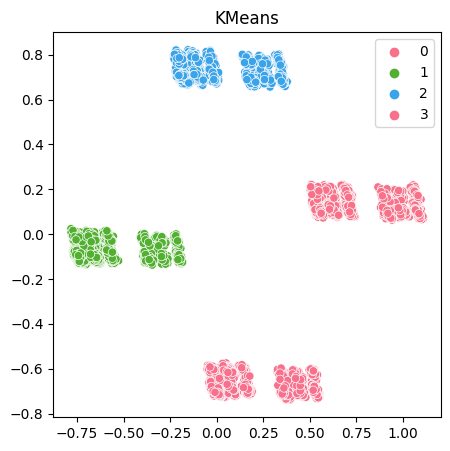

In [108]:
"""
Nombre función: KMeans_core
Parámetros:
    - num_clusters: Entero, Numero de clusters que queremos generar
    - dataframe: DataFrame a analizar
    - col1: String, nombre de la 1era columna a utilizar para el clustering.
    - col2: String, nombre de la 2da columna a utilizar para el clustering.
Tarea funcion: Genera los 'num_clusters' clusters del DataFrame 'dataframe', en base a las columnas 'col1' y 'col2'. Se separa el DataFrame en cada cluster y se almacena en la lista 'clustersDataFrames'
Retorno: Listado de Dataframes 'clustersDataFrames' y el objeto 'km' de KMeans con los parametros dados.
"""
pd.reset_option("mode.chained_assignment")

"""
Nombre funciones: print_KM
Parámetros:
    - data_pca: dataframe normalizado con MinMaxScaler() y PCA() a 2 columnas
    - model: Objeto 'km' de KMeans con los parametros dados
Tarea funcion: Grafica el scatterplot, diferenciando los clusters y sus centroides respectivos.
Retorno: Nada.
"""
def print_KM(data_pca, model):
    fig = plt.figure(figsize=(5, 5))
    ax = sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=model.labels_, palette="husl" )
    ax.set_title("KMeans")
    plt.show()

def KMeans_core(num_clusters, og_dataframe):
    dataframe = og_dataframe
    dataframe = dataframe.drop(columns=["exited"])

    # Scaling
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(dataframe)

    # Descomponemos el dataset en columnas representativas a traves de PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)
    
    # KMEans model
    km = KMeans(n_clusters=num_clusters, n_init=10)
    model = km.fit(data_pca)
    etiquetas=km.labels_
    """
    silhouette_avg = silhouette_score(data_pca, etiquetas) !Funciona, pero tira error en el elbow al parecer cuando solo hay 1 cluster.
    print("Silhouette = ", silhouette_avg)
    """

    y_pred = model.labels_.astype(int)
    print (y_pred)
    
    dataframe["cluster"] = y_pred
    clustersDataFrames=[]
    for eachCluster in range(num_clusters):
        clustersDataFrames.append(dataframe[dataframe.cluster==eachCluster])
    return clustersDataFrames, model, dataframe, data_pca


clusters, km, dataframe, data_pca = KMeans_core(4, bank_df)

print_KM(data_pca, km)



In [109]:
dataframe

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,complain,satisfaction_score,point_earned,d_geography,d_gender,d_card_type,cluster
0,619,42,2,0.00,1,1,1,101348.88,1,2,464,0,0,0,2
1,608,41,1,83807.86,1,0,1,112542.58,1,3,456,1,0,0,2
2,502,42,8,159660.80,3,1,0,113931.57,1,3,377,0,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,5,350,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,5,425,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1,300,0,1,0,3
9996,516,35,10,57369.61,1,1,1,101699.77,0,5,771,0,1,3,1
9997,709,36,7,0.00,1,0,1,42085.58,1,3,564,0,0,2,2
9998,772,42,3,75075.31,2,1,0,92888.52,1,2,339,2,1,1,3


#### Elbow Method

Para evaluar el grado de dispersión de los datos dentro de cada grupo en función del número de clusters, probamos Elbow Method y encontramos el k óptimo.

In [110]:

"""
Nombre funciones: elbowPrinter
Parámetros:
    - k_rng: vector de largo n para probar kmeans con el metodo elbow
    - sse: array de sum of square errors para cada kmean.
Tarea funcion: grafica el elbow method.
Retorno: Nada.
"""

def elbowPrinter(k_rng, sse):
    plt.xlabel("K")
    plt.ylabel("Sum of squared error")
    plt.plot(k_rng, sse)
"""
Nombre funciones: print_elbow_KM
Parámetros:
    - array_pcas: array de dataframes normalizados con MinMaxScaler() y PCA() a 2 columnas
    - array_models: array de Objetos 'km' de KMeans con los parametros dados
Tarea funcion: Grafica un 
"""

def print_elbow_KM(array_pcas, array_models):
    fig = plt.figure(figsize=(20,20))
    for i,data_pca in enumerate(array_pcas):
        ax = fig.add_subplot(5,3,i+1)
        ax = sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=array_models[i].labels_, palette="husl")
        ax.set_title("KMeans " +str(i+1)+" clusters")

def elbow_method(dataset):
    k_rng = range(1,10)
    sse = []
    array_pca, array_km = [], []

    for k in k_rng:
        clusters, km, fitted_df, data_pca=KMeans_core(k, bank_df)
        sse.append(km.inertia_)
        array_pca.append(data_pca)
        array_km.append(km)
    
    return k_rng, sse, array_pca, array_km

In [111]:
k_rng, sse, array_pca, array_km = elbow_method(bank_df)


[0 0 0 ... 0 0 0]
[1 1 1 ... 1 0 1]
[1 1 1 ... 1 2 1]
[1 1 3 ... 1 0 3]
[1 1 3 ... 1 0 4]
[2 2 4 ... 2 1 3]
[6 6 3 ... 6 5 4]
[7 7 4 ... 7 5 1]
[6 6 3 ... 6 1 5]


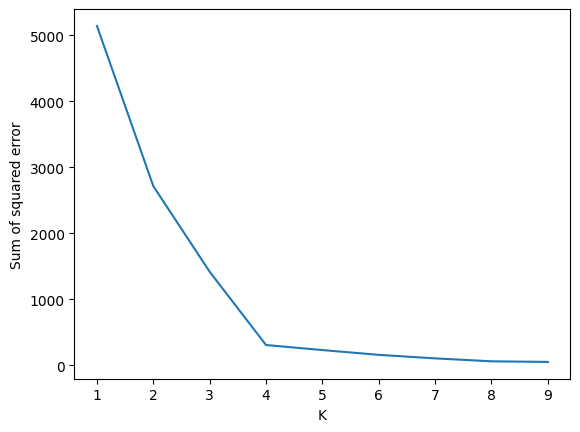

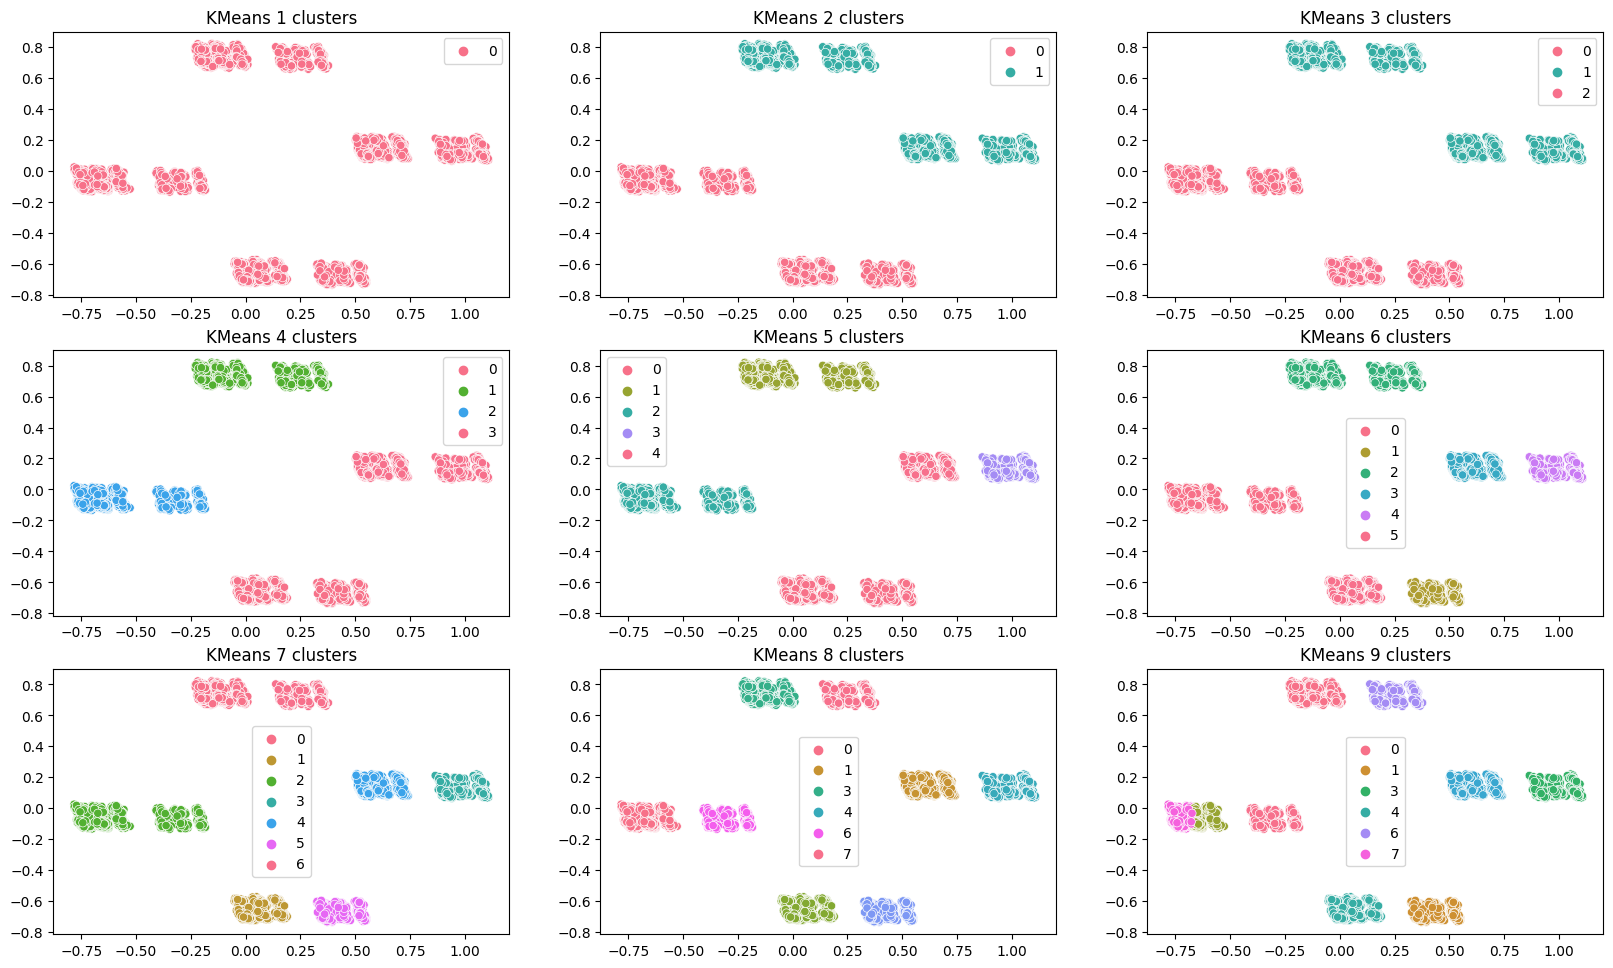

In [112]:
elbowPrinter(k_rng, sse)
print_elbow_KM(array_pca, array_km)

### DBSCAN

In [113]:

def DBSCAN_core(og_dataframe, epsilon):
    df = og_dataframe
    df = df.drop(columns=["exited"])

    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(df)
    # PCA decomposition
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(scaled_df)

    # DBSCAN Model
    model=DBSCAN(eps = epsilon, min_samples=5)
    model = model.fit(df_pca)
    etiquetas=model.labels_
    silhouette_avg = silhouette_score(df_pca, etiquetas)
    print("Silhouette (e=", epsilon, ", MS=5)= ", silhouette_avg)

    df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])  #! BY: GPT Convert df_pca 

    y_pred = model.labels_.astype(int)
    print(type(y_pred))
    
    
    df_pca['cluster'] = y_pred.reshape(-1,1) #!REVISAR ACA, CAMBIE A DF_PCA YA QUE ES LA CAUSA DEL ERROR QUE ESTABA SALIENDO

    print(model)
    return scaled_df, df_pca, model, silhouette_avg
silSco=[]
epsilons=[0.60, 0.56, 0.52, 0.48, 0.44, 0.40, 0.36, 0.32, 0.28, 0.24, 0.20, 0.16, 0.10, 0.06, 0.02]
for i in epsilons:
    print()
    scaled_df_dbscan , df_pca, dbscan_model, silhouetteScore= DBSCAN_core(bank_df, i)
    silSco.append(silhouetteScore)
print(silSco)
# plt.figure(figsize=(7.5, 7.5))
# sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='cluster', palette='husl')#! BY: GPT

# plt.show()


Silhouette (e= 0.6 , MS=5)=  0.508705979684303
<class 'numpy.ndarray'>
DBSCAN(eps=0.6)

Silhouette (e= 0.56 , MS=5)=  0.5087060371929607
<class 'numpy.ndarray'>
DBSCAN(eps=0.56)

Silhouette (e= 0.52 , MS=5)=  0.5087058843308504
<class 'numpy.ndarray'>
DBSCAN(eps=0.52)

Silhouette (e= 0.48 , MS=5)=  0.5087064644103619
<class 'numpy.ndarray'>
DBSCAN(eps=0.48)

Silhouette (e= 0.44 , MS=5)=  0.7909054021446709
<class 'numpy.ndarray'>
DBSCAN(eps=0.44)

Silhouette (e= 0.4 , MS=5)=  0.7908952330213972
<class 'numpy.ndarray'>
DBSCAN(eps=0.4)

Silhouette (e= 0.36 , MS=5)=  0.7909102194082975
<class 'numpy.ndarray'>
DBSCAN(eps=0.36)

Silhouette (e= 0.32 , MS=5)=  0.7909056306242251
<class 'numpy.ndarray'>
DBSCAN(eps=0.32)

Silhouette (e= 0.28 , MS=5)=  0.7909076562656057
<class 'numpy.ndarray'>
DBSCAN(eps=0.28)

Silhouette (e= 0.24 , MS=5)=  0.7909069958226023
<class 'numpy.ndarray'>
DBSCAN(eps=0.24)

Silhouette (e= 0.2 , MS=5)=  0.790905144076459
<class 'numpy.ndarray'>
DBSCAN(eps=0.2)

Silhou

## Métricas de KMeans y DBSCAN

In [114]:
from sklearn.metrics import silhouette_score


silh_dbscan= silhouette_score(scaled_df_dbscan, dbscan_model.labels_)
silh_kmeans= silhouette_score(scaled_df, dbscan_model.labels_)




## 2. Global Poverty and Inequality Dataset (35 pts)
Suponga que le solicitan generar una categorización de paises de acuerdo a sus características socio-demográficoas y socio-económicas en 5 grupos, aplique los métodos de clustering para clusterizar la información de los paises:



> ##### __2.1)__ De acuerdo a su experimentación, ¿es razonable hacer la categorización en 5 grupos para ese conjunto de datos o sugeriría una cantidad distinta?, fundamente experimentalmente su respuesta. (15 pts)
>


> ##### __2.2)__ De acuerdo a la cantidad escogida por usted en la pregunta anterior (ya sea que decidió quedarse con los 5 o una cantidad distinta) haga un análisis de los clusters explique qué características tienen los distintos grupos de paises encontrados. (10 pts)
>


> ##### __2.3)__ Muestre en un mapa del mundo la distribución de los clusters pintando cada país con el color correspondiente al cluster al que pertenece, ¿ve algún patrón? (le será útil usar la librería `geopandas`, acá un ejemplo de como usarla: [link](https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b)) (10 pts)

__Nota:__ Cuando explore el dataset se dará cuenta que cada país no aparece solo una vez sino que varias veces de acuerdo a cada año del cuál se tiene registro, trate esta información temporal como usted estime conveniente para poder resolver el problema enunciado al principio justificando su decisión.



## 3. E-Commerce Data (30)
Aplique el algoritmo apriori (puede encontrar una buena implementación en la librería `mlxtend`) sobre el conjunto de transacciones y obtenga los 100 itemsets más significativos.


Tenga en cuenta lo siguiente:

* Cada fila es un evento de compra/devolución de un producto realizado por un cliente, para evitar trabajar con las devoluciones elimine todas aquellas filas que contengan valores negativos de `Quantity` y `UnitPrice`.
* En el método apriori de `mlxtend` se pide que las transacciones sean procesadas con un transformador llamado `TransactionEncoder` el cual requiere que los conjuntos de articulos comprados en en una misma transaccion se presenten como una lista de productos, acá hay un ejemplo de dos transacciones en el formato requerido:
```
[['pan', 'mantequilla', 'mermelada'],
['trapero', 'lavaloza', 'polera', 'pantalon', 'cereales']]
```
Para poder hacer esto necesitará "agrupar" los elementos comprados según el código de la boleta (`InvoiceNo`).
* En las transacciones realizadas hay varios errores de ingreso del código del producto y la descripción del mismo, específicamente el problema está en que hay casos donde un código de producto está ligado a más de una descripción, sin embargo, solo una de las descripciones es la correcta: La más común, acá un par de ejemplos:



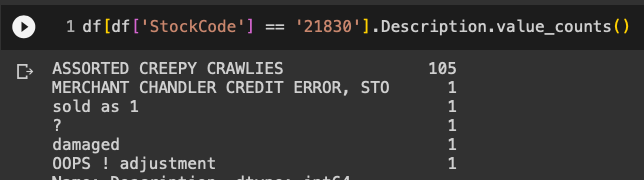




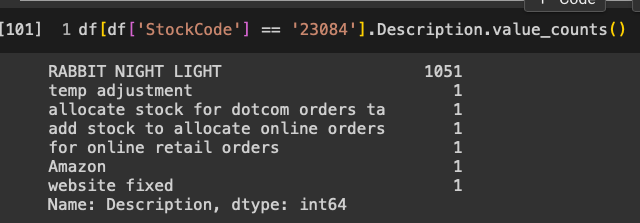

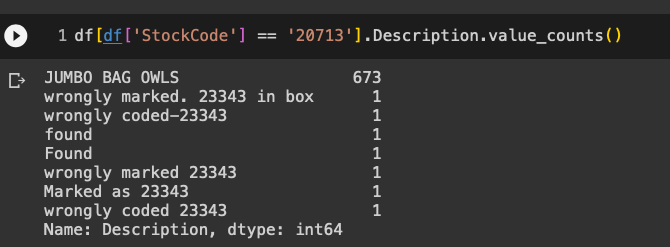

Preprocese adecuadamente las transacciones para quedarse solo con aquellas transacciones que tengan, para cada código de producto, la descripción más común encontrada para ese código. __No realizar esto implicará caer en una penalización de 15 pts.__

In [115]:
print(ecom_df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [116]:
negativePrice_df= ecom_df[ecom_df['UnitPrice']<=0] #Veremos cuantas filas tienen registros de precios=0 o negativos
negativePrice_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,12/8/2011 13:58,0.0,NaN,United Kingdom
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,12/8/2011 13:58,0.0,NaN,United Kingdom
538554,581408,85175,NaN,20,12/8/2011 14:06,0.0,NaN,United Kingdom


In [117]:
negativeQuantity_df= ecom_df[ecom_df['Quantity']<=0] #Revisamos cuantas filas tienen cantidades de prod<=0
negativeQuantity_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


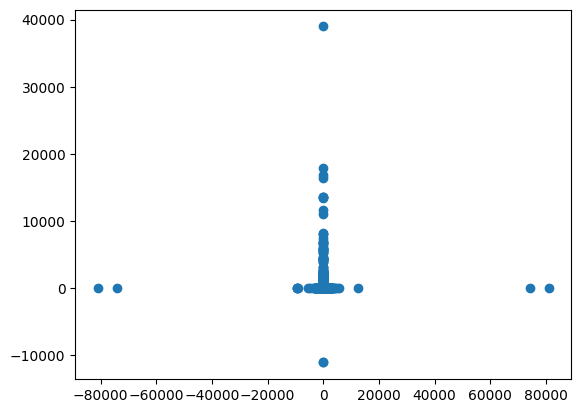

In [118]:

plt.scatter(ecom_df['Quantity'], ecom_df['UnitPrice'])